In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data

In [2]:
train_data = pd.read_csv("train.csv", index_col = 'Id')
test_data = pd.read_csv("test.csv", index_col = "Id")

X_train = train_data.drop(['SalePrice'], axis = 1)
y1 = train_data['SalePrice']

X = pd.concat([X_train, test_data], axis = 0)

In [3]:
y1.isnull().sum()

0

In [4]:
print(X_train.shape)
print(test_data.shape)

(1460, 79)
(1459, 79)


In [5]:
numCols = list(X_train.select_dtypes(exclude='object').columns)
catCols = list(X_train.select_dtypes(include='object').columns)

In [6]:
print(numCols)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [7]:
print(catCols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# Exploratory Data Analysis

### Target Variable

We want to take a look at the distribution of our target variable.

We find out that it is right-skewed. 

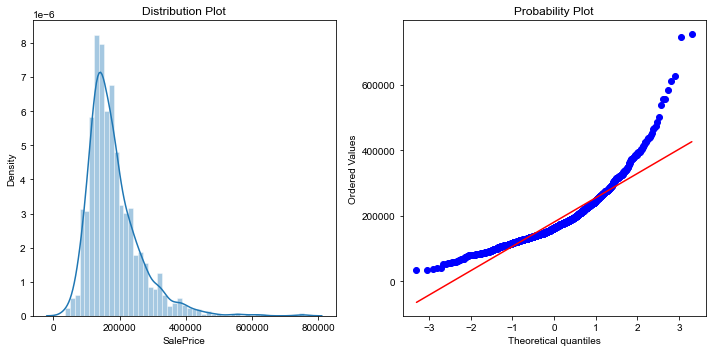

In [8]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.set_style('darkgrid')

sns.distplot(y1, ax=axes[0])
axes[0].set_title('Distribution Plot')

axes[1] = stats.probplot((y1), plot=plt)
plt.tight_layout()

plt.savefig('SalePrice_distribution')

#### Log Transformation

Log transformation shows more normal distribution, so this will be our target variable.

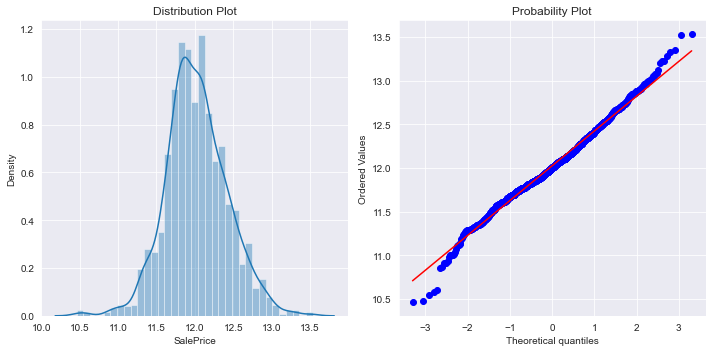

In [9]:
y = np.log(y1)
fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.distplot(y, ax=axes[0])
axes[0].set_title('Distribution Plot')

axes[1] = stats.probplot((y), plot=plt)
plt.tight_layout()

plt.savefig('log_SalePrice_distribution')

### Numerical Variables

Finding numerical variables most correlated with SalePrice.

Notice TotalBsmtSF and 1stFlrSF. Could these be combined? 
Does TotRmsAbvGrd correlate with those two variables as well?

In [10]:
corr_matrix = train_data.corr().SalePrice.sort_values(ascending = False)
corr_matrix.head(11)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

sklearn has a feature called Recursive Feature Elimination which will give us rankings of the top features. 

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10, step=1)
selector = rfe.fit(X_train.fillna(0).select_dtypes(exclude='object'), y)
selectedFeatures = list(
    X.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures

['OverallQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'KitchenAbvGr']

We still haven't done a lot of data cleaning, so by no means is this accurate for our final model, but it should give us an idea moving forward. We can see how these top 10 variables look against our target variable. 

Also notice these 4 variables: BsmtFullBath, BsmtHalfBath, FullBath, HalfBath. Could they be combined?

#### OverallQual

Overall Quality has the highest correlation, as well as the most weight (based on RFE).

Intuitively, it makes sense that the higher quality house will have a higher price.

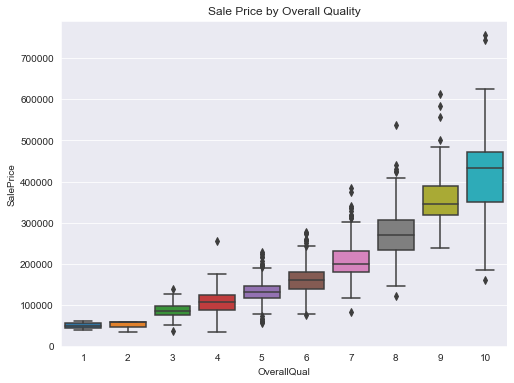

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Overall Quality')

plt.savefig('OverallQual Dist')

#### GrLivArea

We can see the linear relationship between Above Ground Living Area and Sale Price, but has a few outliers (two houses in lower-right corner)

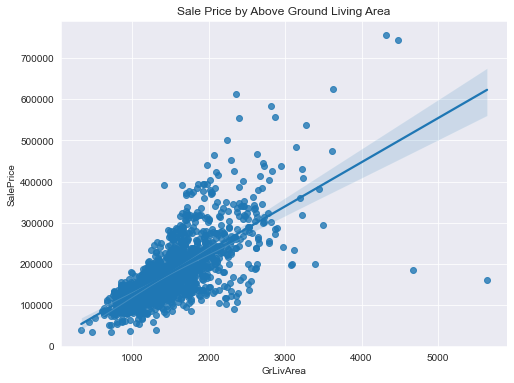

In [13]:
plt.figure(figsize=(8, 6))
sns.regplot(x= 'GrLivArea', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Above Ground Living Area')

plt.savefig('GrLivArea Dist')

#### GarageCars

Houses with 4 car garages are cheaper than houses with only 3 car garages. 

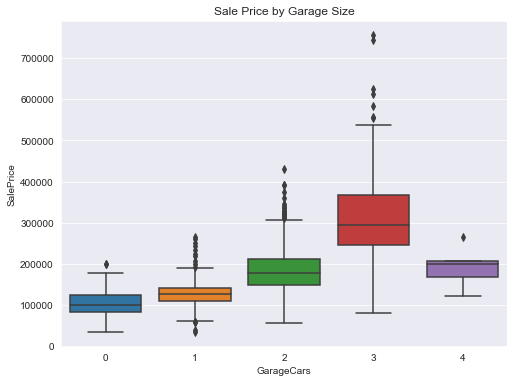

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Garage Size')

plt.savefig('GarageCars Dist')

#### YearBuilt

Generally speaking, newer houses have higher Sale Prices, however, there are a few outliers.

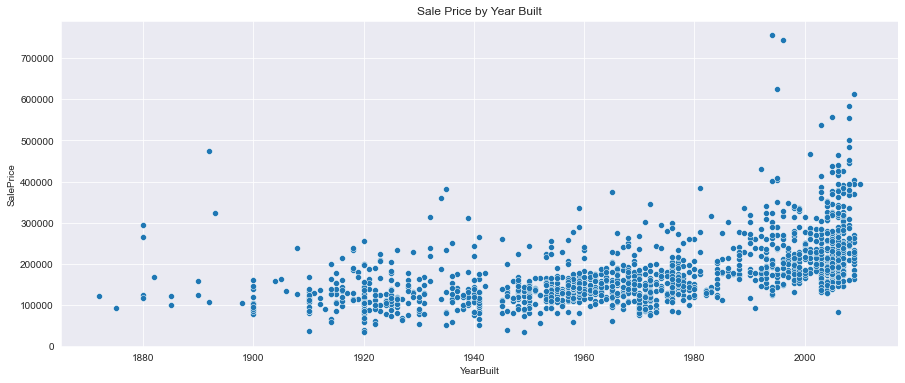

In [15]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_data)
title = plt.title('Sale Price by Year Built')

plt.savefig('YearBuilt Dist')

### Categorical Variables

In [16]:
print(catCols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


#### Ordinal Variables

In [17]:
ordinal_cols = ['LotShape', 'LandSlope', 'ExterQual',
               'ExterCond','BsmtQual', 'BsmtCond',
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'HeatingQC','CentralAir', 'KitchenQual',
               'Functional','FireplaceQu', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'PavedDrive', 
               'Fence', 'PoolQC']

#### Nominal Variables

In [18]:
nominal_cols = ['MSSubClass', 'MSZoning', 'LandContour',
                  'LotConfig', 'Neighborhood', 'BldgType',
                  'HouseStyle', 'RoofStyle', 'MasVnrType',
                  'Foundation', 'GarageType', 'SaleType',
                  'SaleCondition', 'Condition1','Exterior1st',
                  'Exterior2nd', 'MiscFeature', 'Alley', 'Utilities', 
                'Electrical',]

# Correlation

We can see that there is multicollinearity in our dataset.

- GarageYrBlt and YearBuilt
- 1stFlrSF and 2ndFlrSF
- TotRmsAbvGrd and GrLivArea
- GarageArea and GarageCars
- GrLivArea and 2ndFlrSF

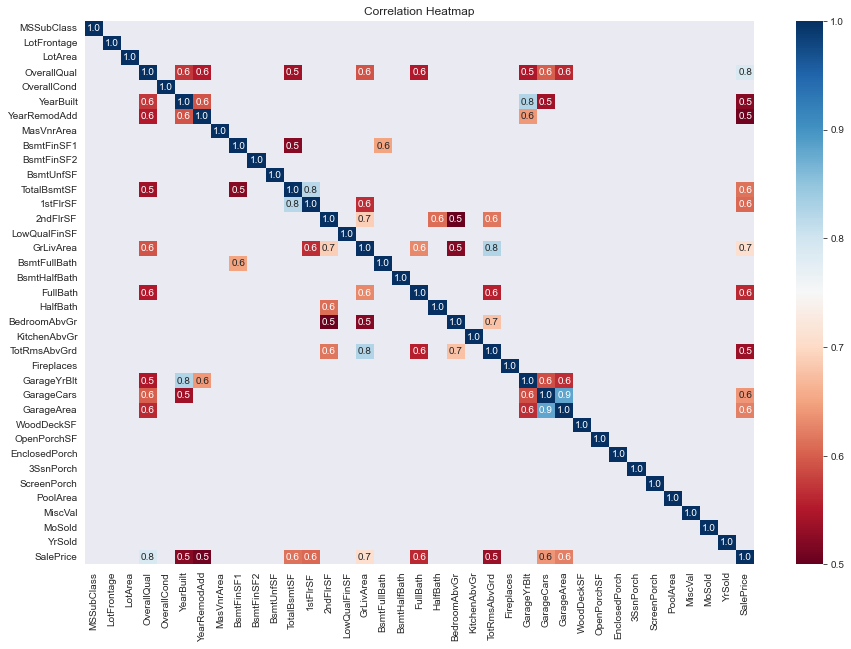

In [19]:
corr_mat = train_data.corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='RdBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

plt.savefig('Correlation Heatmap')

# Feature Engineering

If we take a look at the data description, "NA" means the feature doens't exist rather than a "missing value." So we will replace "NA" in categorical features to "None" whenever it is not a true null. Then impute the remaining missing values

- Numerical features: use sample median to account for outliers as well as for discrete variables. (Only two variables: Lot Frontage and MasVnrArea)
- Ordinal features: use sample mode
- Nominal features: use sample mode

We then have to encode categorical variables.
- Ordinal: Label Encoding
- Nominal: One-hot Encoding (Dummy Variables)

From our correlation matrix, as well as our earlier theories, we should create new variables.

- totalSqFt = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
- totalBath = FullBath + BsmtFullBath + 0.5(HalfBath + BsmtHalfBath)


### Missing Values

In [20]:
missing_data_count = X.isnull().sum()
missing_data = pd.DataFrame({
    'Count': missing_data_count,
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

In [21]:
missing_data.head(10)

,Count
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageCond,159
GarageYrBlt,159


#### Ordinal Variables

In [22]:
for feature in ordinal_cols:
    X[feature] = X[feature].fillna("None")

#### Nominal Variables

In [23]:
for feature in nominal_cols:
    X[feature] = X[feature].fillna("None")

#### Nominal Variables.2

Although NA means None, we need to represent these variables specifically with 0 since we will be combining them to make a new variable.

In [24]:
special_nom_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'CentralAir']

for feature in special_nom_cols:
    X[feature] = X[feature].fillna(0)

#### Numerical Variables

#### Lot Frontage

Impute LotFrontage with the median of the neighborhood it's in.

In [25]:
neighborhood_medians = X.groupby('Neighborhood')['LotFrontage'].median()
neighborhood_medians = neighborhood_medians.fillna(np.median(neighborhood_medians))

In [26]:
X['LotFrontage'] = X['LotFrontage'].fillna(X['Neighborhood'])
X['LotFrontage'] = X['LotFrontage'].map(lambda x: neighborhood_medians[x] if type(x)==str else x)


In [27]:
X['LotFrontage'].isna().sum()

0

#### Masonry

In [28]:
MasVnrArea_Median = X['MasVnrArea'].median()
X['MasVnrArea'].fillna(MasVnrArea_Median, inplace = True)

In [29]:
X['MasVnrArea'].isna().sum()

0

#### GarageYrBuilt


In [30]:
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])

In [31]:
X['GarageYrBlt'].isna().sum()

0

In [32]:
missing_num_list = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                    'TotalBsmtSF', 'GarageCars', 'GarageArea']

for feature in missing_num_list:
    X[feature] = X[feature].fillna(X[feature].median())

Check if there are any missing values left.

In [33]:
sum(X.isnull().sum())

0

## Outliers

Recall how we noticed GrLivArea had some outliers, we can remove these.

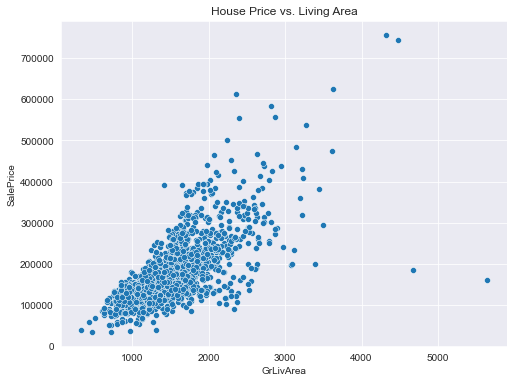

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
title = plt.title('House Price vs. Living Area')

plt.savefig('GrLivArea')

In [35]:
outlier_index = train_data[(train_data.GrLivArea > 4000)
                           & (train_data.SalePrice < 200000)].index
X.drop(outlier_index, axis=0, inplace=True)
y.drop(outlier_index, axis=0, inplace=True)

Use RobustScaler to tackle outliers and StandardScaler to standardize variables.

In [36]:
from sklearn.preprocessing import RobustScaler, StandardScaler

numerical_cols = list(X.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

standard_scaler = StandardScaler()
X[numerical_cols] = standard_scaler.fit_transform(X[numerical_cols])




### Creating New Variables

Creating new variables totalSqFeet and totalBath, and dropping the variables they were made from.

In [37]:
X['totalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['totalBath'] = X['FullBath'] + X['BsmtFullBath'] + 0.5 * (X['HalfBath'] + X['BsmtHalfBath'])


In [38]:
X.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FullBath', 
        'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], axis=1, inplace=True)


### Label Encoding

Ordinal Variables are Label Encoded. I made a copy to re-modify when I get to the non-linear models, as dummified variables can mess with tree-based models and their performance. 

In [39]:
X_tree = X.copy()

In [40]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for feature in ordinal_cols:
    X[feature] = label_encoder.fit_transform(X[feature])

### One-hot Encoding

In [41]:
X = pd.get_dummies(X, drop_first=True)

In [42]:
X.shape

(2917, 202)

Now that our data is cleaned, we can split our data back into train and test

In [43]:
ntest = len(test_data)
X_train = X.iloc[:-ntest, :]
X_testset = X.iloc[-ntest:, :]

print(X_train.shape)
print(X_testset.shape)

(1458, 202)
(1459, 202)


We have 210 variables; we can eliminate some based on correlation with sale price. 
We will remove the 100 least correlated features.

In [44]:
features_keep = list(abs(X_train.corrwith(y1)).sort_values(ascending=False)[:-100].index)
X_train = X_train[features_keep]
X_testset = X_testset[features_keep]

# Modeling

Regularized Regression:
- Multiple Linear Regression
- Ridge
- Lasso
- Elastic Net

Non-linear:
- Random Forest
- LightGBM
- XGBoost




In [45]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


from sklearn.metrics import mean_squared_error, r2_score


#### Train Test Split

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X_train, y, test_size=0.3, 
                                                    random_state=0)


### Functions

The goal is to find a model that minimizes RSME. Our target variable will be log of Sale Price.

In [47]:
def get_residuals(model, X, Y):
    
    residuals = Y - model.predict(X)
    
    return residuals

In [48]:
def model_evaluate(model, X, Y):
    rmse = mean_squared_error(Y, model.predict(X), squared = False)
    
    r2 = r2_score(Y, model.predict(X))
    
    
    if len(np.where(model.predict(X)>20)[0]) > 0: 
        rmse_dollars = np.nan
    else:
        rmse_dollars = mean_squared_error(np.exp(Y), 
                            np.exp(model.predict(X)), 
                            squared = False)
    
    print('RMSE: ', rmse)
    print('r^2: ', r2)
    print('RMSE: $', rmse_dollars)
    
    
    return rmse, r2, rmse_dollars

In [49]:
def plot_the_model(model, x_train, y_train, x_test, y_test):

    fig, axs = plt.subplots(1,2) 
    fig.set_figheight(5)
    fig.set_figwidth(10)

    x = np.linspace(10, 14.5, 100)
    y = np.linspace(10, 14.5, 100)
    

    # Actual vs. Predicted Plot
    
    axs[0].scatter(model.predict(x_train), 
         y_train, color='blue')
    axs[0].plot(x,y, 'r-')
 
    axs[0].set_ylabel('Actual log of Sale Price')
    axs[0].set_xlabel('Predicted log of Sale Price')
    axs[0].tick_params(axis='x')
    axs[0].legend(['line','Train'])
    
    axs[1].scatter(model.predict(x_test), 
         y_test, color='green') 
    axs[1].plot(x,y, 'r-')

    axs[1].set_ylabel('Actual log of Sale Price')
    axs[1].set_xlabel('Predicted log of Sale Price')
    axs[1].tick_params(axis='x')
    axs[1].legend(['line','Test'])

In [50]:
# Initializing for model comparison later on

model_descrp = []
r2_log_train = []
r2_log_test = []
rmse_log_train = []
rmse_log_test = []
rmse_dollars_train = []
rmse_dollars_test = []

In [51]:
def append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars):
    
    r2_log_train_temp = r2_train
    r2_log_test_temp = r2_test
    rmse_log_train_temp = rmse_train
    rmse_log_test_temp = rmse_test
    rmse_dollars_train_temp = rmse_train_dollars
    rmse_dollars_test_temp = rmse_test_dollars

    model_descrp.append(which_model)
    if r2_log_train_temp <= 1 and r2_log_train_temp > 0:
        r2_log_train.append(r2_log_train_temp)
    elif r2_log_train_temp > 1:   
        r2_log_train.append(1000)
    else:
        r2_log_train.append(-1000)

    if r2_log_test_temp <= 1 and r2_log_test_temp > 0:
        r2_log_test.append(r2_log_test_temp)
    elif r2_log_test_temp > 1:   
        r2_log_test.append(1000)
    else:
        r2_log_test.append(-1000)
    
    if rmse_log_train_temp <= 10:
        rmse_log_train.append(rmse_log_train_temp)
    elif rmse_log_train_temp > 10:   
        rmse_log_train.append(1000)

    if rmse_log_test_temp <= 10:
        rmse_log_test.append(rmse_log_test_temp)
    elif rmse_log_test_temp > 10:   
        rmse_log_test.append(1000)
        
    rmse_dollars_train.append(rmse_dollars_train_temp)
    rmse_dollars_test.append(rmse_dollars_test_temp)

## Linear Regression

In [52]:
def get_LinearRegression(X,Y):
    
    lm = LinearRegression()
    
    model = lm.fit(X, Y)
    print('LM model object created.')
    
    return model

In [53]:
lm_model = get_LinearRegression(X_train, y_train)

rmse_train, r2_train, rmse_train_dollars= model_evaluate(lm_model, X_train, y_train)

LM model object created.
RMSE:  0.1041444142631724
r^2:  0.9303078822558088
RMSE: $ 18333.797441140665


In [54]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(lm_model, X_test, y_test)

RMSE:  0.11408818463343615
r^2:  0.9230047022233708
RMSE: $ 21328.52879103529


Our model's R2 score is close to 0.93 on the unseen data. Our model can explain 92.5% of the variance in log SalePrice in our test data.

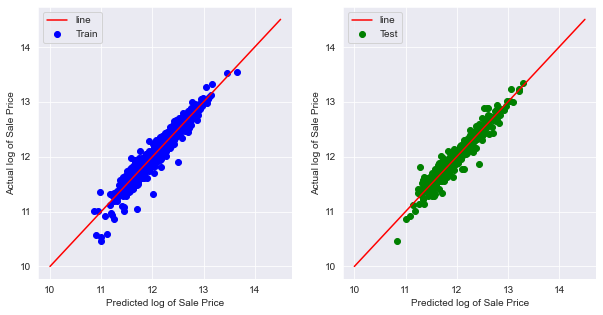

In [55]:
plot_the_model(lm_model, X_train, y_train, X_test, y_test)

plt.savefig('Linear Model')

In order to make valid references from our regression, the residuals should follow a normal distribution.

Skewness:  -1.1316562045808463


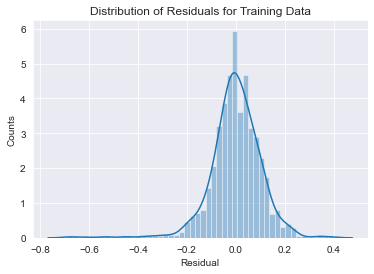

In [56]:
residuals_train = get_residuals(lm_model, X_train, y_train)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Training Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_train.skew())

plt.savefig('Distribution of Residuals Train_LM')

Skewness:  -0.12560157579403436


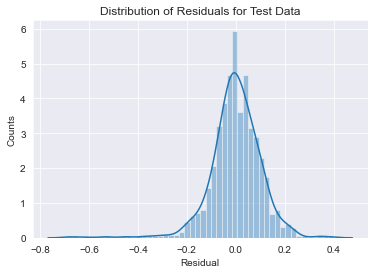

In [57]:
residuals_test = get_residuals(lm_model, X_test, y_test)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Test Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_test.skew())

plt.savefig('Distribution of Residuals Test_LM')

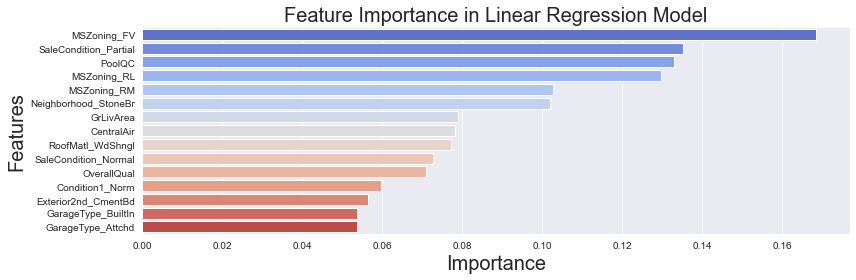

In [58]:
coefs = pd.DataFrame(zip(X_train, lm_model.coef_),
   columns=['Feature', 'Importance']
)

coefs = coefs.sort_values(by = 'Importance', ascending = False)

f, ax = plt.subplots(figsize = (12,4))
sns.barplot(data=coefs.loc[coefs.Importance>=0.05], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')

ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance in Linear Regression Model', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=10)
f.tight_layout()

plt.savefig('Feature Importance LM')


In [59]:
best_features_linear = dict()
best_features_linear['Linear Regression'] = coefs.loc[coefs.Importance>=0.05].Feature.values

In [60]:
which_model = "Linear Regression"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

## Regularized Regression

### Ridge Regression



In [61]:
def get_Ridge(X, Y):
    
    skfold = KFold(n_splits=5, shuffle=True, random_state=0)
    ridge_gs = Ridge()
    ridge_gs.set_params(normalize=False)
    
    # Searching for best Lambda
    params = { "alpha": np.linspace(10,20, 100) }

    gs = GridSearchCV(ridge_gs, params, scoring = "neg_mean_squared_error", cv=skfold)
    gs.fit(X, Y)
    
    model = gs.best_estimator_
    
    print('Ridge model object created.')
    print(gs.best_estimator_)
    
    return model

In [62]:
ridge_model = get_Ridge(X_train, y_train)

Ridge model object created.
Ridge(alpha=17.77777777777778)


In [63]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(ridge_model, X_train, y_train)

RMSE:  0.10696713036768205
r^2:  0.9264788336206942
RMSE: $ 18840.00672095439


In [64]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(ridge_model, X_test, y_test)

RMSE:  0.11490668968004886
r^2:  0.9218959615325651
RMSE: $ 21840.889730195362


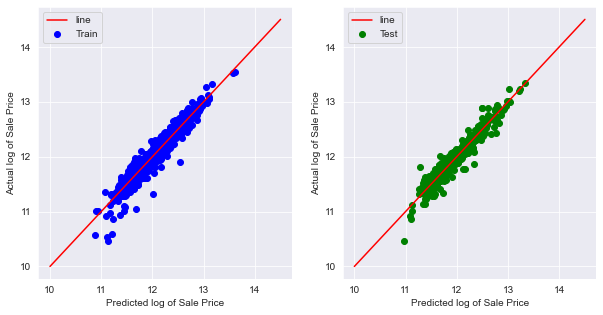

In [65]:
plot_the_model(ridge_model, X_train, y_train, X_test, y_test)

plt.savefig('Ridge Regression')

Skewness:  -1.3942254378331862


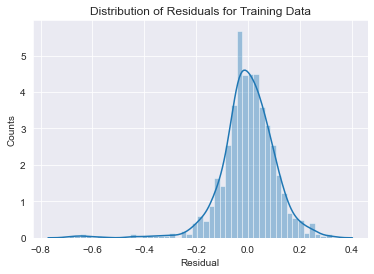

In [66]:
residuals_train = get_residuals(ridge_model, X_train, y_train)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Training Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_train.skew())

plt.savefig('Distribution of Residuals Train_RM')

Skewness:  -0.21965850478208387


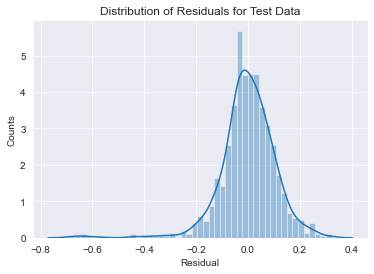

In [67]:
residuals_test = get_residuals(ridge_model, X_test, y_test)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Test Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_test.skew())

plt.savefig('Distribution of Residuals Test_RM')

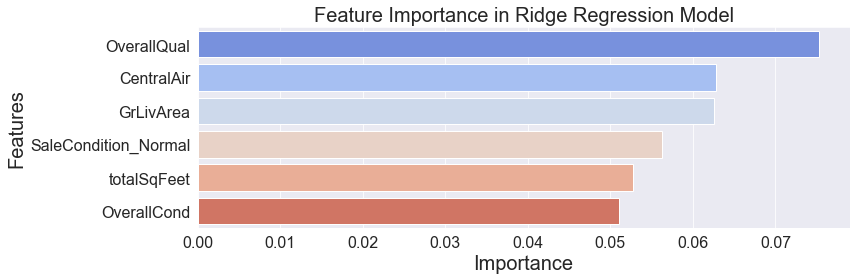

In [68]:
coefs = pd.DataFrame(zip(X_train, ridge_model.coef_),
   columns=['Feature', 'Importance']
)

coefs = coefs.sort_values(by = 'Importance', ascending = False)

f, ax = plt.subplots(figsize = (12,4))
sns.barplot(data=coefs.loc[coefs.Importance>=0.05], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')

ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance in Ridge Regression Model', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()

plt.savefig('Feature Importance Ridge')

In [69]:

best_features_linear['Ridge Regression Model'] = coefs.loc[coefs.Importance>=0.05].Feature.values


In [70]:
which_model = "Ridge Regression"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

### Lasso Regression

In [71]:
def get_Lasso(X, Y):
    

    skfold = KFold(n_splits=5, shuffle=True, random_state=0)
    lasso_gs  = Lasso()
    lasso_gs.set_params(normalize=False)
    
    # Searching for best lambda
    params = { "alpha": np.linspace(0.01, 0.1, 10)}

    gs = GridSearchCV(lasso_gs, params, scoring = "neg_mean_squared_error", cv=skfold)
    gs.fit(X, Y)
    
    model = gs.best_estimator_
    
    print('Lasso model object created.')
    print(gs.best_estimator_)
    
    return model

In [72]:
lasso_model = get_Lasso(X_train, y_train)

Lasso model object created.
Lasso(alpha=0.01)


In [73]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(lasso_model, X_train, y_train)

RMSE:  0.12540994415060155
r^2:  0.8989408486009389
RMSE: $ 22976.439026384363


In [74]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(lasso_model, X_test, y_test)

RMSE:  0.12621593470420484
r^2:  0.905765216045171
RMSE: $ 24076.081152738945


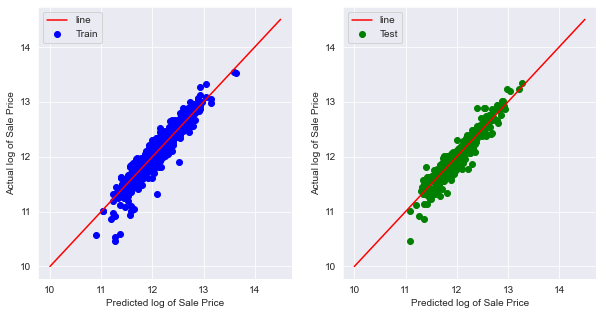

In [75]:
plot_the_model(lasso_model, X_train, y_train, X_test, y_test)

plt.savefig('Lasso Model')

Skewness:  -1.4101250793376077


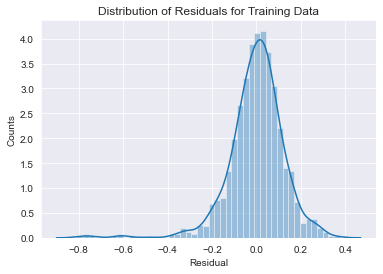

In [76]:
residuals_train = get_residuals(lasso_model, X_train, y_train)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Training Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_train.skew())

plt.savefig('Distribution of Residuals Train_Lasso')

Skewness:  -0.6204835724656473


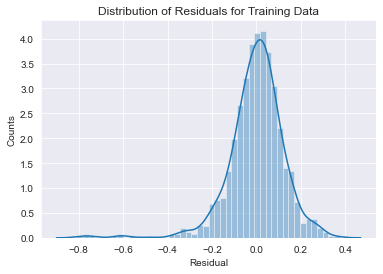

In [77]:
residuals_test = get_residuals(lasso_model, X_test, y_test)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Training Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_test.skew())

plt.savefig('Distribution of Residuals Test_Lasso')

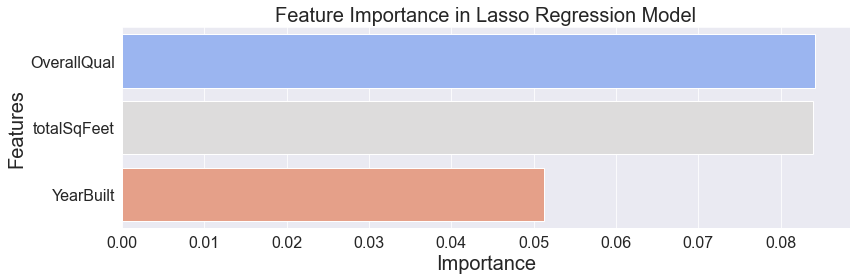

In [78]:
coefs = pd.DataFrame(zip(X_train, lasso_model.coef_),
   columns=['Feature', 'Importance']
)

coefs = coefs.sort_values(by = 'Importance', ascending = False)

f, ax = plt.subplots(figsize = (12,4))
sns.barplot(data=coefs.loc[coefs.Importance>=0.05], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')

ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance in Lasso Regression Model', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()

plt.savefig('Feature Importance Lasso')

In [79]:

best_features_linear['Lasso Regression Model'] = coefs.loc[coefs.Importance>=0.05].Feature.values


In [80]:
which_model = "Lasso Regression"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

### Elastic Net

In [81]:
def get_ElasticNet(X, Y):
    
    skfold = KFold(n_splits=5, shuffle=True, random_state=0)
    elastic_gs  = ElasticNet()
    elastic_gs.set_params(normalize=False)

    params = [{
        "alpha": np.linspace(.01, .02, 5),
        "l1_ratio": np.linspace(0.01, 0.05, 5)
    }]

    gs = GridSearchCV(elastic_gs, params, scoring = "neg_mean_squared_error", cv=skfold)
    gs.fit(X_train, y_train)
    
    model = gs.best_estimator_
    
    print('Elastic Net model object created.')
    print(gs.best_estimator_)
    
    return model

In [82]:
Elastic_Net_model = get_ElasticNet(X_train, y_train)

Elastic Net model object created.
ElasticNet(alpha=0.0125, l1_ratio=0.02)


In [83]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(Elastic_Net_model, X_train, y_train)

RMSE:  0.10739406054423785
r^2:  0.92589078300047
RMSE: $ 18986.160366672753


In [84]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(Elastic_Net_model, X_test, y_test)

RMSE:  0.1147325054628495
r^2:  0.9221325740306252
RMSE: $ 21801.640917243953


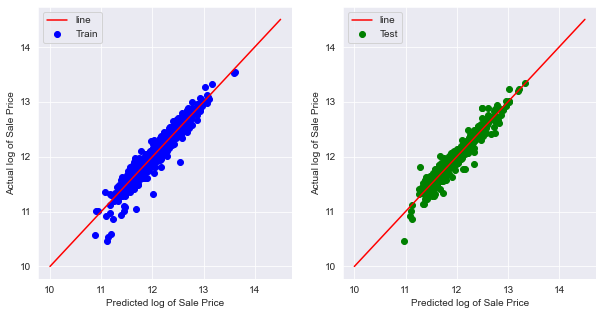

In [85]:
plot_the_model(Elastic_Net_model, X_train, y_train, X_test, y_test)

Skewness:  -1.3721075559884564


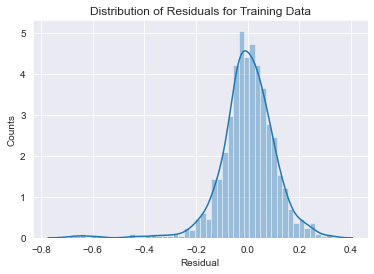

In [86]:
residuals_train = get_residuals(Elastic_Net_model, X_train, y_train)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Training Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_train.skew())

Skewness:  -0.2058444057569334


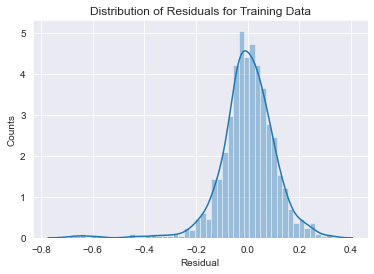

In [87]:
residuals_test = get_residuals(Elastic_Net_model, X_test, y_test)
sns.distplot(residuals_train)
plt.title('Distribution of Residuals for Training Data')
plt.ylabel('Counts')
plt.xlabel('Residual')

print("Skewness: ", residuals_test.skew())

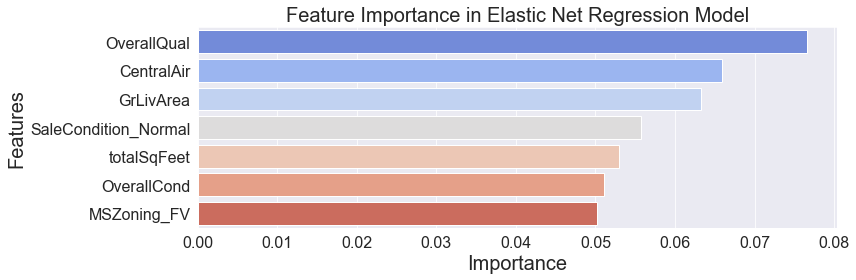

In [88]:
coefs = pd.DataFrame(zip(X_train, Elastic_Net_model.coef_),
   columns=['Feature', 'Importance']
)

coefs = coefs.sort_values(by = 'Importance', ascending = False)

f, ax = plt.subplots(figsize = (12,4))
sns.barplot(data=coefs.loc[coefs.Importance>=0.05], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')

ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance in Elastic Net Regression Model', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()

In [89]:

best_features_linear['Elastic Net Regression Model'] = coefs.loc[coefs.Importance>=0.05].Feature.values


In [90]:
which_model = "Elastic Net Regression"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

# Non-linear Models

As mentioned previously, I will be cleaning this data a little bit differently than I did for the linear models.

In [91]:
label_encoder = LabelEncoder()

for feature in catCols:
    X_tree[feature] = label_encoder.fit_transform(X_tree[feature])

In [92]:
ntest = len(test_data)
X_train_tree = X.iloc[:-ntest, :]
X_testset_tree = X.iloc[-ntest:, :]

print(X_train_tree.shape)
print(X_testset_tree.shape)

(1458, 202)
(1459, 202)


In [93]:
X_train, X_test, y_train, y_test = train_test_split( X_train_tree, y, test_size=0.3, 
                                                    random_state=0)

## Random Forest

In [94]:
def get_RandomForests_model(X, Y):

    skfold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    gs_randomForest = RandomForestRegressor()

    para_grid_forest = [{
        "n_estimators": [100, 1000, 250],
        "max_features": [4, 5, 6, 8, 10],
        "min_samples_split":[2, 4, 6, 8, 10],
        "random_state": [0]}]
    gs = GridSearchCV(gs_randomForest, 
                        para_grid_forest, 
                        scoring='neg_mean_squared_error', 
                        cv = skfold,
                        n_jobs=-1)
    
    gs.fit(X, Y)
    
    model = gs.best_estimator_
    
    print('Random Forests model object created.')
    print(gs.best_estimator_)
    
    return model

In [95]:
random_forest_model = get_RandomForests_model(X_train, y_train)

Random Forests model object created.
RandomForestRegressor(max_features=10, n_estimators=1000, random_state=0)


In [96]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(random_forest_model, X_train, y_train)

RMSE:  0.05348010930144432
r^2:  0.9816220836422673
RMSE: $ 12926.110621763011


In [97]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(random_forest_model, X_test, y_test)

RMSE:  0.14086356705204556
r^2:  0.8826237509076887
RMSE: $ 31388.251023069697


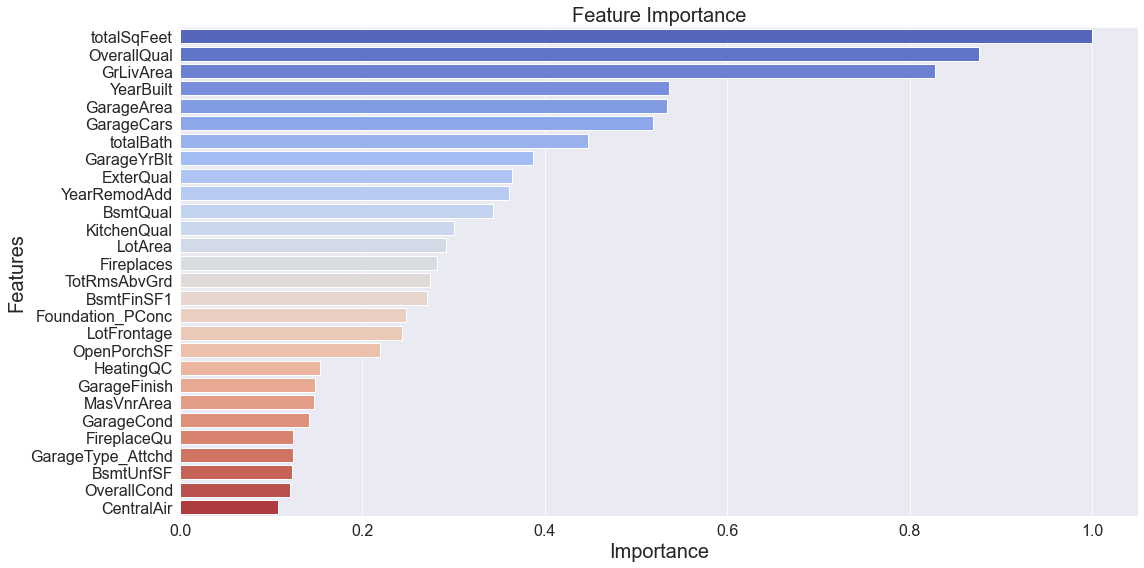

In [98]:
# Create plot data
plot_data = pd.DataFrame(zip(X, random_forest_model.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)

# Normalize so features are compared amongst themselves
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance at least 0.1
f, ax = plt.subplots(figsize = (16,8))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')
ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()


plt.savefig('Feature Importance RF')

In [99]:
# Store the best features
best_features = dict()
best_features['Random Forest'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

In [100]:
which_model = "Random Forest"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

## Gradient Boosting

In [101]:
def get_GradientBoosting_model(X, Y):
    from sklearn import ensemble
    from sklearn.ensemble import GradientBoostingRegressor

    skfold = KFold(n_splits=5, shuffle=True, random_state=0)
    gs_gbm = GradientBoostingRegressor()

    para_grid_gbm = [{
        "learning_rate": [0.001, 0.005, 0.01],
        "n_estimators": [500, 1000, 2000],
        "max_features": [4, 5, 6, 8],
        "min_samples_split":[2, 4, 6, 8, 10],
        "random_state": [0]}]
    gs = GridSearchCV(gs_gbm, 
                        para_grid_gbm, 
                        scoring='neg_mean_squared_error', 
                        cv = skfold,
                        n_jobs=-1)
    gs.fit(X, Y)
    
    model = gs.best_estimator_
    
    print('Random Forests model object created.')
    print(gs.best_estimator_)
    
    return model

In [102]:
gb_model = get_GradientBoosting_model(X_train, y_train)

Random Forests model object created.
GradientBoostingRegressor(learning_rate=0.01, max_features=8,
                          min_samples_split=6, n_estimators=2000,
                          random_state=0)


In [103]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(gb_model, X_train, y_train)

RMSE:  0.07370334793949877
r^2:  0.9650951215423389
RMSE: $ 12697.142678677583


In [104]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(gb_model, X_test, y_test)

RMSE:  0.12005726200514999
r^2:  0.9147371720536814
RMSE: $ 23695.171087346687


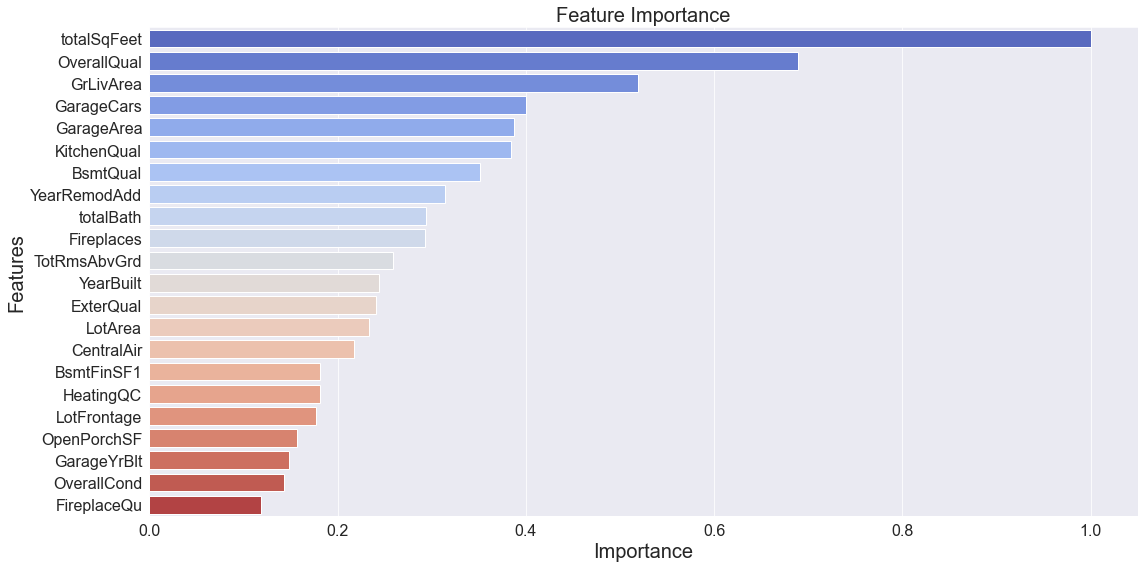

In [105]:
# Create plot data
plot_data = pd.DataFrame(zip(X, gb_model.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance at least 0.1
f, ax = plt.subplots(figsize = (16,8))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')
ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()

plt.savefig('Feature Importance Gradient Boosting')

In [106]:
best_features['Grandient Boosting'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values

In [107]:
which_model = "Gradient Boosting"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

# LightGBM

In [108]:
def get_lightGBM_model(X, Y):
    
    skfold = KFold(n_splits=5, shuffle=True, random_state=0)

    gs_lightGBM = LGBMRegressor()
    
    para_grid_lightGBM ={
    'n_estimators': [200],
    'max_depth': np.linspace(start = 8, stop = 13, num = 6, dtype = int),
    'max_bin': np.linspace(start = 100, stop = 400, num = 4, dtype = int),
    'reg_alpha': np.linspace(start = 0.2, stop = 0.5, num = 4, dtype = float),
    'reg_lambda': np.linspace(start = 0.3, stop = 0.6, num = 4, dtype = float)
}
    
    gs = GridSearchCV(gs_lightGBM,
                      para_grid_lightGBM,
                      scoring='neg_mean_squared_error', 
                      cv = skfold,
                      n_jobs=-1,
                      verbose = 2)
    
    gs.fit(X,Y)
    
    model = gs.best_estimator_
    
    print('Light GBM object created.')
    print(gs.best_estimator_)
    
    return model


In [109]:
lgbm_model = get_lightGBM_model(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5; total time= 

[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.3s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=100, max

[CV] END max_bin=100, max_depth=12, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=12, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=100, max_depth=12, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=100, max_depth=12, n_estimators=200, reg_alpha=0.5, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=13, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=13, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=13, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=13, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=100, max_depth=13, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=100, max_depth=

[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=100, max_depth=8, n_esti

[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.2, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.1s
[CV] END max_bin=100, max_depth=8, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=100, max_depth=8, n_esti

Light GBM object created.
LGBMRegressor(max_bin=400, max_depth=8, n_estimators=200, reg_alpha=0.3,
              reg_lambda=0.6)


In [110]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(lgbm_model, X_train, y_train)

RMSE:  0.03332917960203569
r^2:  0.9928622563638806
RMSE: $ 7378.461306069105


In [111]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(lgbm_model, X_test, y_test)

RMSE:  0.13150259971163336
r^2:  0.8977056750548023
RMSE: $ 24221.931170651416


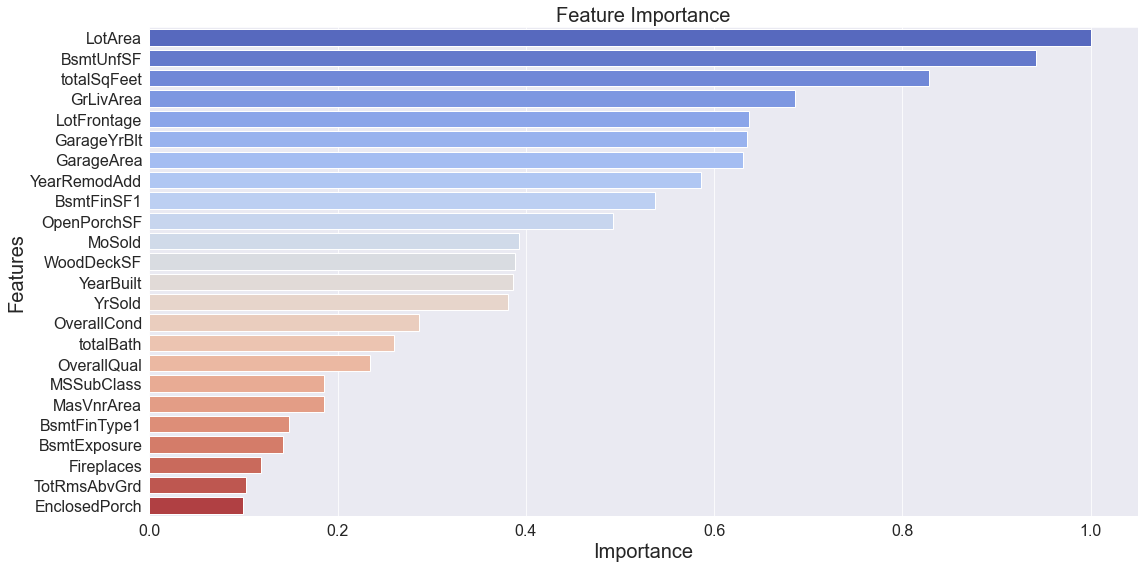

In [112]:
# Create plot data
plot_data = pd.DataFrame(zip(X, lgbm_model.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance at least 0.1
f, ax = plt.subplots(figsize = (16,8))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')
ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()

plt.savefig('Feature Importance LightGBM')

In [113]:
best_features['Light GBM'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values


In [114]:
which_model = "light GBM"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

## XGBoost

In [115]:
def get_XGB_model(X, Y):
    
    skfold = KFold(n_splits=5, shuffle=True, random_state=0)

    gs_XGBM = XGBRegressor()
    
    para_grid_XGBM ={
    'n_estimators': [200],
    'max_depth': np.linspace(start = 8, stop = 13, num = 6, dtype = int),
    'max_bin': np.linspace(start = 100, stop = 400, num = 4, dtype = int),
    'reg_alpha': np.linspace(start = 0.2, stop = 0.5, num = 4, dtype = float),
    'reg_lambda': np.linspace(start = 0.3, stop = 0.6, num = 4, dtype = float)
}
    
    gs = GridSearchCV(gs_XGBM,
                      para_grid_XGBM,
                      scoring='neg_mean_squared_error', 
                      cv = skfold,
                      n_jobs=-1,
                      verbose = 1)
    
    gs.fit(X,Y)
    
    model = gs.best_estimator_
    
    print('XGBM object created.')
    print(gs.best_estimator_)
    
    return model

In [116]:
xgb_model = get_XGB_model(X_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
XGBM object created.
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=100, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.4, reg_lambda=0.3, ...)


In [117]:
rmse_train, r2_train, rmse_train_dollars= model_evaluate(xgb_model, X_train, y_train)

RMSE:  0.026950541780651
r^2:  0.995332904383769
RMSE: $ 5748.230277408337


In [118]:
rmse_test, r2_test, rmse_test_dollars= model_evaluate(xgb_model, X_test, y_test)

RMSE:  0.13819413078987974
r^2:  0.8870302778144762
RMSE: $ 27403.889231823076


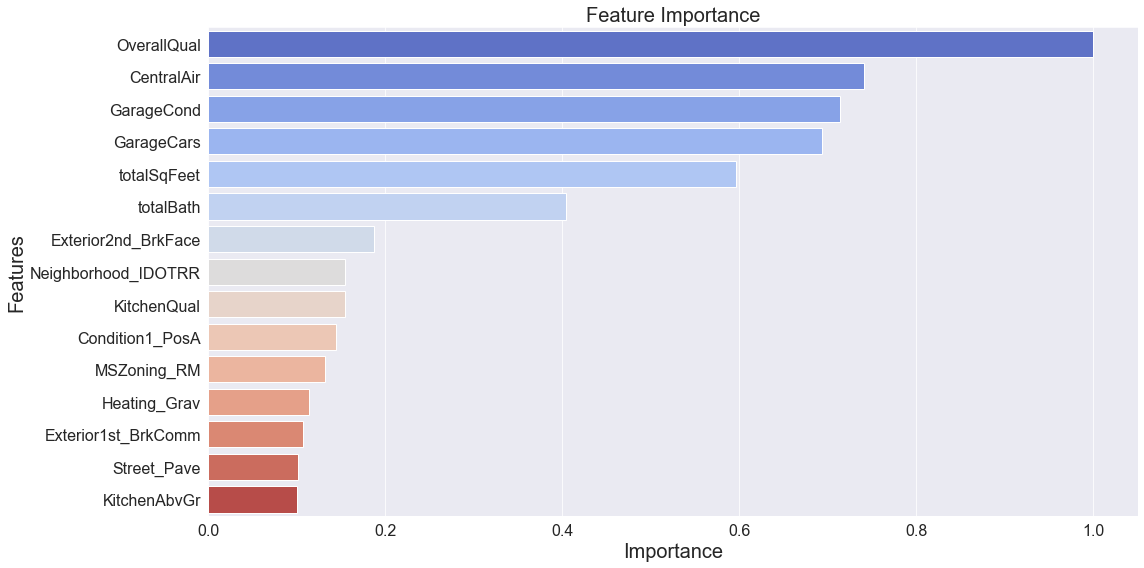

In [119]:
# Create plot data
plot_data = pd.DataFrame(zip(X, xgb_model.feature_importances_),
             columns = ['Feature', 'Importance'])
plot_data = plot_data.sort_values(by = 'Importance', ascending = False)
plot_data['Importance'] = plot_data['Importance'].values / plot_data['Importance'].values.max()

# Plot importance at least 0.1
f, ax = plt.subplots(figsize = (16,8))
sns.barplot(data=plot_data.loc[plot_data.Importance>=0.1], 
            y='Feature', 
            x='Importance',
            palette='coolwarm')
ax.set_xlabel('Importance', fontsize = 20)
ax.set_ylabel('Features', fontsize = 20)
ax.set_title('Feature Importance', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=16)
f.tight_layout()

plt.savefig('Feature Importance XGBoost')

In [120]:
best_features['XGBoost'] = plot_data.loc[plot_data.Importance>=0.1].Feature.values


In [121]:
which_model = "XGBoost"

append_metrics(which_model, r2_train, r2_test, rmse_train, rmse_test, rmse_train_dollars, rmse_test_dollars)

## Comparing Model Results

In [122]:
pd.options.display.float_format = '{:,.4f}'.format
zipped = list(zip(model_descrp,
                 rmse_log_train, rmse_log_test,
                 rmse_dollars_train, rmse_dollars_test,
                 r2_log_train, r2_log_test))

results = pd.DataFrame(zipped, columns=['model',
                                       'rmse log train',
                                       'rmse log test',
                                       'rmse_dollars_train', 
                                       'rmse_dollars_test',
                                       'r2 train',
                                       'r2 test',
                                       ])

results_sorted = results.sort_values('rmse log test', ascending = True)
results_sorted.head(10)

,model,rmse log train,rmse log test,rmse_dollars_train,rmse_dollars_test,r2 train,r2 test
0,Linear Regression,0.1041,0.1141,"18,333.7974","21,328.5288",0.9303,0.9230
3,Elastic Net Regression,0.1074,0.1147,"18,986.1604","21,801.6409",0.9259,0.9221
1,Ridge Regression,0.1070,0.1149,"18,840.0067","21,840.8897",0.9265,0.9219
5,Gradient Boosting,0.0737,0.1201,"12,697.1427","23,695.1711",0.9651,0.9147
2,Lasso Regression,0.1254,0.1262,"22,976.4390","24,076.0812",0.8989,0.9058
6,light GBM,0.0333,0.1315,"7,378.4613","24,221.9312",0.9929,0.8977
7,XGBoost,0.0270,0.1382,"5,748.2303","27,403.8892",0.9953,0.8870
4,Random Forest,0.0535,0.1409,"12,926.1106","31,388.2510",0.9816,0.8826


Interesting to see that Linear Regression has the lowest RMSE with Ridge Regression coming in second.

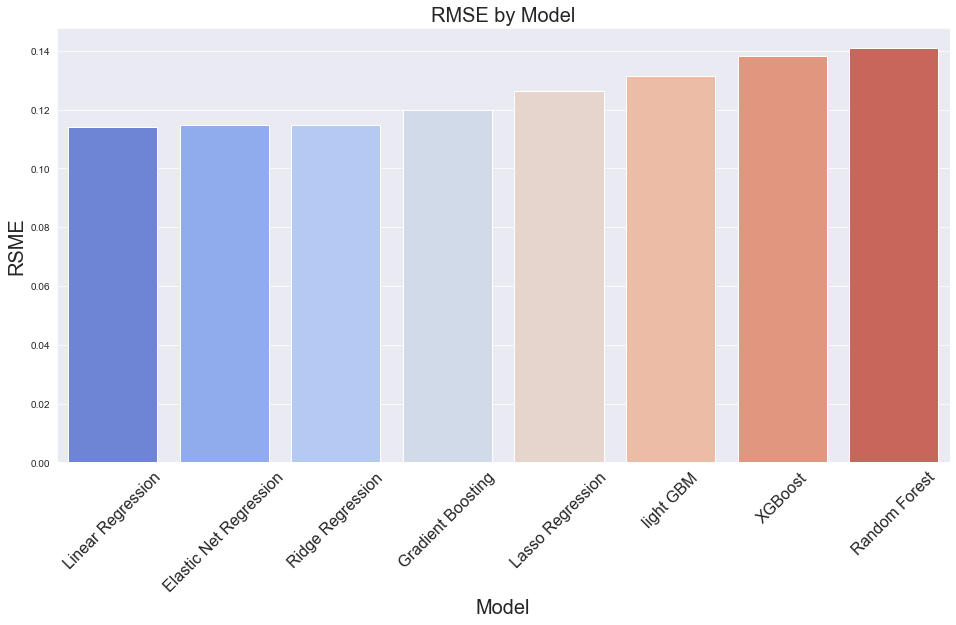

In [123]:
f, ax = plt.subplots(figsize = (16,8))
sns.barplot(data=results_sorted, 
            y='rmse log test', 
            x='model',
            palette='coolwarm')
ax.set_xlabel('Model', fontsize = 20)
ax.set_ylabel('RSME', fontsize = 20)
ax.set_title('RMSE by Model', fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=16, rotation = 45)

plt.savefig('RMSE by Model')

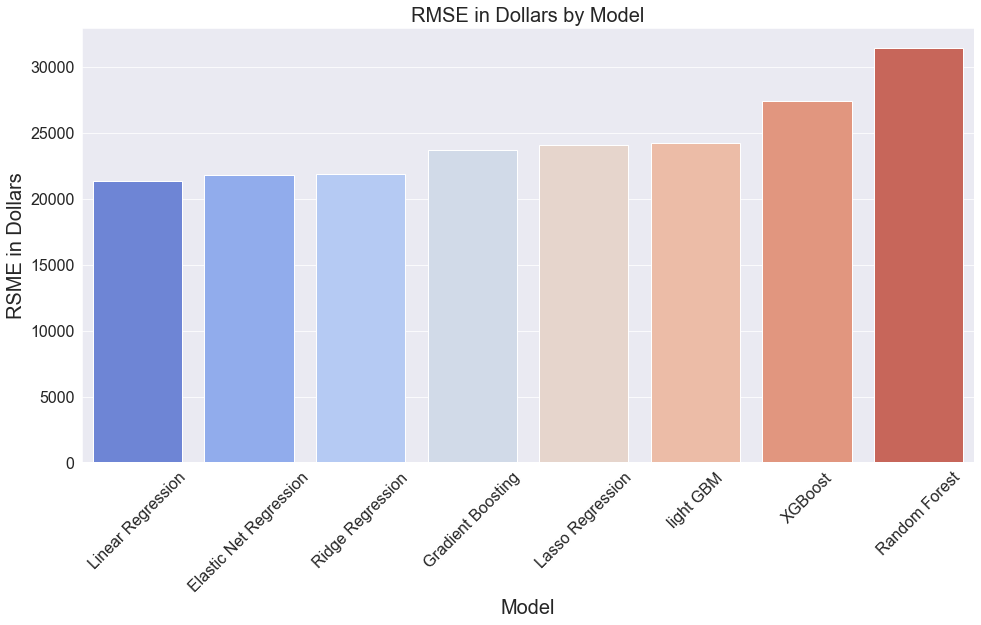

In [124]:
f, ax = plt.subplots(figsize = (16,8))
sns.barplot(data=results_sorted, 
            y='rmse_dollars_test', 
            x='model',
            palette='coolwarm')
ax.set_xlabel('Model', fontsize = 20)
ax.set_ylabel('RSME in Dollars', fontsize = 20)

ax.set_title('RMSE in Dollars by Model', fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=16, rotation = 45)
ax.tick_params(axis='y', which='major', labelsize=16)

plt.savefig('RMSE in Dollars by Model')

### Most Frequent "Best" Features

In [125]:
from collections import Counter

keep_features_linear = list()

for best_feature in best_features_linear.values():
    keep_features_linear = keep_features_linear + list(best_feature)
keep_features_count_linear = Counter(keep_features_linear)

In [126]:
print(best_features_linear)

{'Linear Regression': array(['MSZoning_FV', 'SaleCondition_Partial', 'PoolQC', 'MSZoning_RL',
       'MSZoning_RM', 'Neighborhood_StoneBr', 'GrLivArea', 'CentralAir',
       'RoofMatl_WdShngl', 'SaleCondition_Normal', 'OverallQual',
       'Condition1_Norm', 'Exterior2nd_CmentBd', 'GarageType_BuiltIn',
       'GarageType_Attchd'], dtype=object), 'Ridge Regression Model': array(['OverallQual', 'CentralAir', 'GrLivArea', 'SaleCondition_Normal',
       'totalSqFeet', 'OverallCond'], dtype=object), 'Lasso Regression Model': array(['OverallQual', 'totalSqFeet', 'YearBuilt'], dtype=object), 'Elastic Net Regression Model': array(['OverallQual', 'CentralAir', 'GrLivArea', 'SaleCondition_Normal',
       'totalSqFeet', 'OverallCond', 'MSZoning_FV'], dtype=object)}


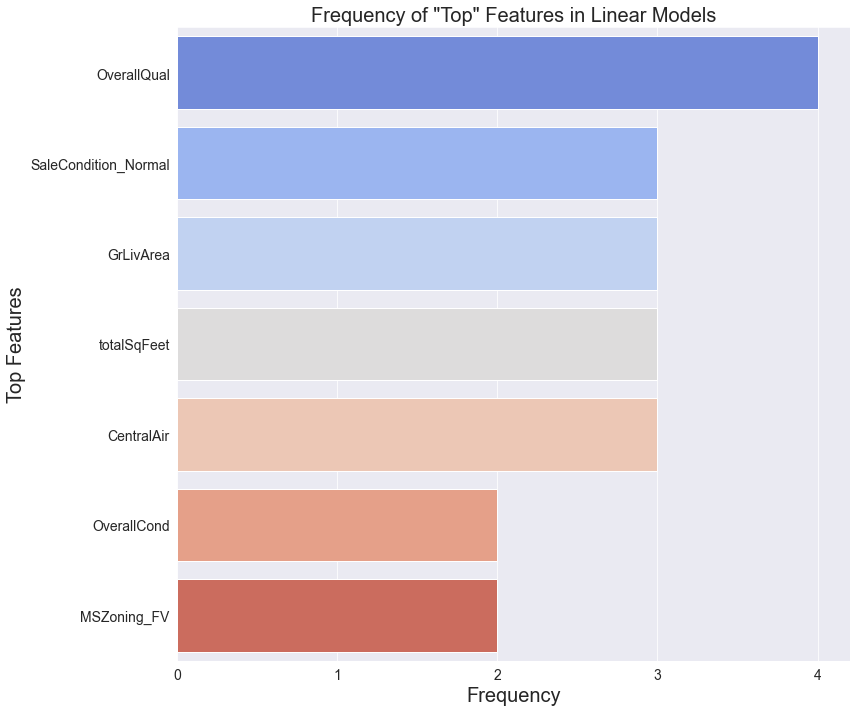

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END max_bin=300, max_depth=12, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=

In [130]:
plot_data_linear = pd.DataFrame(zip(keep_features_count_linear.keys(), 
                             keep_features_count_linear.values()),
             columns = ['Feature', 'Count'])
plot_data_linear = plot_data_linear.sort_values(by = 'Count', ascending = False)

# Plot features that are considered "important" in multiple models
f, ax = plt.subplots(figsize = (12,10))
sns.barplot(data=plot_data_linear.loc[plot_data_linear.Count>1], 
            y='Feature', 
            x='Count',
            palette='coolwarm')

ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Frequency', fontsize = 20)
ax.set_ylabel('Top Features', fontsize = 20)
ax.set_title('Frequency of "Top" Features in Linear Models', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
f.tight_layout()

plt.savefig('Best Features in Linear Models')

In [128]:
keep_features = list()
for best_feature in best_features.values():
    keep_features = keep_features + list(best_feature)
keep_features_count = Counter(keep_features)

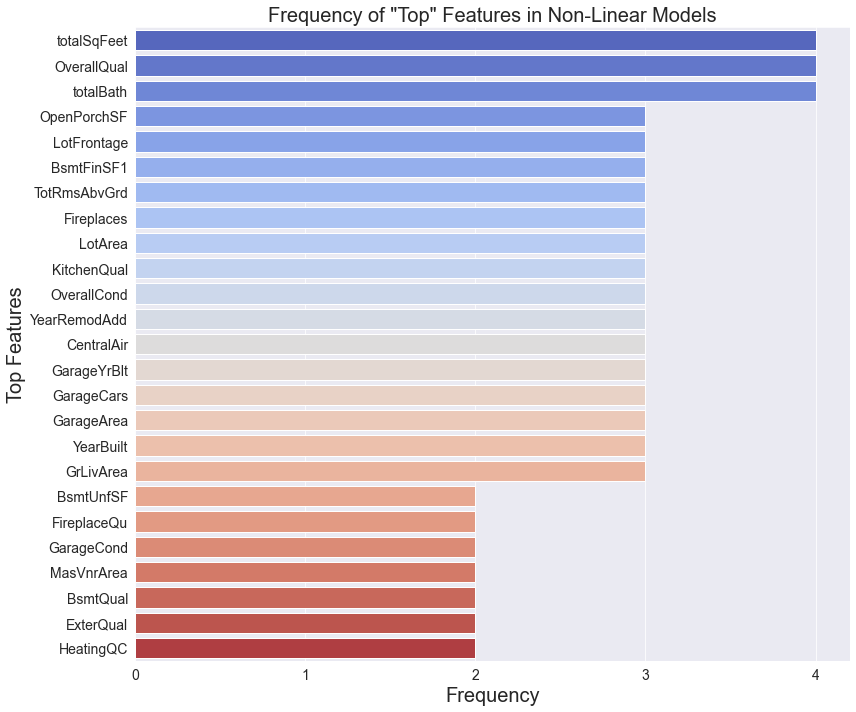

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END max_bin=300, max_depth=

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END max_bin

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=300, max_depth=12, n_estimators=200, reg_alpha=0.2, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=300, max_depth=12, n_estimators=200, reg_alpha=0.2, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=12, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.6; total time=   0.2s
[CV] END max_bin

[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.39999999999999997; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.3, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.4, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.3; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.39999999999999997; total time=   0.1s
[CV] END max_bin=300, max_depth=11, n_estimators=200, reg_alpha=0.5, reg_lambda=0.6; total time=   0.1s
[CV] END max_bin=300, max_depth=12, n_estimators=200, reg_alpha=0.2, reg_lambda=0.3; total time=   0.2s
[CV] END max_bin=300, max_depth=12, n_estimators=200, reg_alpha=0.2, reg_lambda=0.5; total time=   0.2s
[CV] END max_bin=300, max_depth=

In [129]:
plot_data = pd.DataFrame(zip(keep_features_count.keys(), keep_features_count.values()),
             columns = ['Feature', 'Count'])
plot_data = plot_data.sort_values(by = 'Count', ascending = False)

# Plot features that are considered "important" in multiple models
f, ax = plt.subplots(figsize = (12,10))
sns.barplot(data=plot_data.loc[plot_data.Count>1], 
            y='Feature', 
            x='Count',
            palette='coolwarm')

ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Frequency', fontsize = 20)
ax.set_ylabel('Top Features', fontsize = 20)
ax.set_title('Frequency of "Top" Features in Non-Linear Models', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)
f.tight_layout()

plt.savefig('Best Features in Non-Linear Models')